In [1]:
import tensorflow as tf
import cv2
import keras
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
from keras.callbacks import ModelCheckpoint
import pickle

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with open('/content/drive/My Drive/Colab Notebooks/origaacrima36/x_train.pkl', 'rb') as file:
    x_train = pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/origaacrima36/x_test.pkl', 'rb') as file:
    x_test = pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/origaacrima36/y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/origaacrima36/y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)
#print(x_train)


In [4]:

print("x_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(y_train.shape[0], "train samples")
print(y_test.shape[0], "test samples")
print(x_train.shape[1:])

x_train shape: (2480, 2)
y_test shape: (621, 2)
2480 train samples
621 test samples
(36, 36, 3)


In [5]:

# Import Densenet from Keras
from keras.applications.densenet import DenseNet201
from keras.layers import Dense, GlobalAveragePooling2D, Input, Activation, BatchNormalization
from keras.models import Model
from keras import backend as K

In [6]:
inputs = Input(shape=(36,36,3))
model = DenseNet201(weights='imagenet', include_top=False)(inputs)

# Our FC layer
flat1 = Flatten()(model)
dense1 = Dense(units=256, use_bias=True)(flat1)
batchnorm1 = BatchNormalization()(dense1)
act1 = Activation(activation='relu')(batchnorm1)
drop1 = Dropout(rate=0.5)(act1)

# Output
out = Dense(units=2, activation='softmax')(drop1)

# Create Model
model = Model(inputs=inputs, outputs=out)

74836368/74836368 [==============================] - 1s 0us/step


In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 36, 36, 3)]       0         
                                                                 
 densenet201 (Functional)    (None, None, None, 1920   18321984  
                             )                                   
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 256)               491776    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256)               0     

In [8]:
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
model.fit(x_train, y_train, epochs=90, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/90
20/20 [==============================] - 100s 857ms/step - loss: 0.7150 - accuracy: 0.6310 - val_loss: 0.6809 - val_accuracy: 0.5974
Epoch 2/90
20/20 [==============================] - 3s 157ms/step - loss: 0.4583 - accuracy: 0.8069 - val_loss: 0.6568 - val_accuracy: 0.5668
Epoch 3/90
20/20 [==============================] - 4s 187ms/step - loss: 0.3411 - accuracy: 0.8722 - val_loss: 0.6318 - val_accuracy: 0.6715
Epoch 4/90
20/20 [==============================] - 3s 146ms/step - loss: 0.2537 - accuracy: 0.9101 - val_loss: 0.6048 - val_accuracy: 0.7375
Epoch 5/90
20/20 [==============================] - 3s 146ms/step - loss: 0.1913 - accuracy: 0.9399 - val_loss: 0.5797 - val_accuracy: 0.7488
Epoch 6/90
20/20 [==============================] - 3s 147ms/step - loss: 0.1710 - accuracy: 0.9496 - val_loss: 0.5647 - val_accuracy: 0.7842
Epoch 7/90
20/20 [==============================] - 4s 192ms/step - loss: 0.1108 - accuracy: 0.9706 - val_loss: 0.4951 - val_accuracy: 0.8309
Epoc

In [10]:
predictions = model.predict(x_test)

20/20 [==============================] - 9s 160ms/step


In [11]:
binary_predictions = (predictions > 0.5).astype(int)

In [12]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions)

# Print accuracy
print(f"Accuracy on test data: {accuracy:.4f}")


Accuracy on test data: 0.9227


In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.29570162296295166
Test accuracy: 0.9227052927017212


In [14]:
score = model.evaluate(x_train, y_train, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.0010514201130717993
Test accuracy: 1.0


In [15]:
y_pred = model.predict(x_test)


20/20 [==============================] - 0s 19ms/step


In [16]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))


In [17]:
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])


In [18]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred.ravel())


In [19]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test.ravel(), y_pred.ravel())


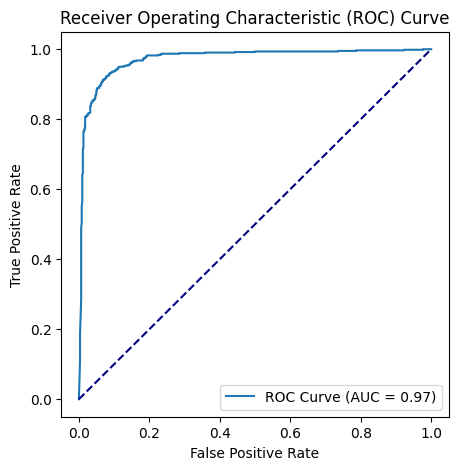

In [23]:
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def calculate_specificity_sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    return specificity, sensitivity

y_test_single = np.argmax(y_test, axis=1)
y_pred_single = np.argmax(y_pred, axis=1)

specificity, sensitivity = calculate_specificity_sensitivity(y_test_single, y_pred_single)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)

Specificity: 0.8972602739726028
Sensitivity: 0.9452887537993921


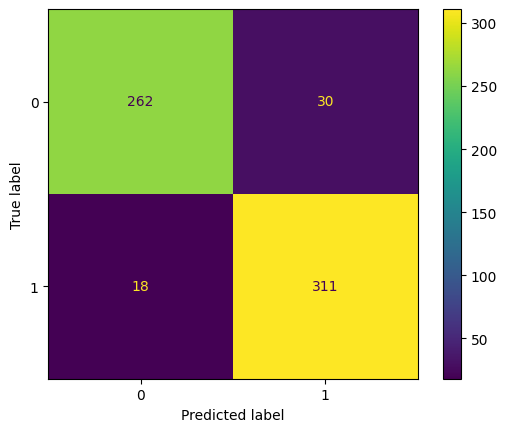

In [22]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test_single, y_pred_single)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()